# Computing the energy of water on IBM

## Set experiment parameters

In [332]:
ibm_computer: str = "ibm_fez"
qubits = [153, 152, 151, 150, 149, 148, 147, 146, 145, 144, 143, 136, 123, 124]
nshots: int = 50_000

len(qubits)

14

## Setup

In [333]:
from collections import Counter
from typing import Tuple

import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif"})
import networkx as nx
import numpy as np
import pickle

from cirq.contrib.qasm_import import circuit_from_qasm
import openfermion as of

import qiskit
from qiskit import qasm2, qasm3
from qiskit_aer import AerSimulator
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

# from mitiq.interface.mitiq_qiskit import to_qiskit

## Read in the Hamiltonian and ansatz circuit

In [334]:
hamiltonian = of.jordan_wigner(
        of.get_fermion_operator(
    of.chem.MolecularData(filename="monomer_eqb.hdf5").get_molecular_hamiltonian()
    )
)
nqubits = of.utils.count_qubits(hamiltonian)
nterms  = len(hamiltonian.terms)

print(f"Hamiltonian acts on {nqubits} qubit(s) and has {nterms} term(s).")

Hamiltonian acts on 14 qubit(s) and has 1620 term(s).


In [335]:
water_eqb_circuits = pickle.load(open("./water_eqb_circuits", "rb"))

for error, circuit, layout in water_eqb_circuits:
    print("Error =", error)
    print("Circuit stats:", circuit.count_ops())

Error = 0.037555931951644084
Circuit stats: OrderedDict([('sx', 31), ('rz', 25), ('cz', 15), ('x', 10), ('barrier', 1)])
Error = 0.03379578090144264
Circuit stats: OrderedDict([('sx', 62), ('rz', 50), ('cz', 30), ('x', 10), ('barrier', 2)])
Error = 0.030943222097420175
Circuit stats: OrderedDict([('sx', 112), ('rz', 81), ('cz', 55), ('x', 11), ('barrier', 3)])
Error = 0.027695213747492176
Circuit stats: OrderedDict([('sx', 171), ('rz', 115), ('cz', 82), ('x', 13), ('barrier', 4)])
Error = 0.02339403255849959
Circuit stats: OrderedDict([('sx', 241), ('rz', 149), ('cz', 117), ('x', 13), ('barrier', 5)])
Error = 0.01931645584224384
Circuit stats: OrderedDict([('sx', 299), ('rz', 171), ('cz', 144), ('x', 12), ('barrier', 6)])
Error = 0.01475382803189973
Circuit stats: OrderedDict([('sx', 367), ('rz', 208), ('cz', 179), ('x', 12), ('barrier', 7)])
Error = 0.008882504924585533
Circuit stats: OrderedDict([('sx', 413), ('rz', 225), ('cz', 201), ('x', 12), ('barrier', 8)])
Error = 0.00578208149

In [336]:
error, circuit, layout = water_eqb_circuits[5]
circuit.draw(fold=-1, idle_wires=False)

global phase: π/2
              ┌───┐                                                                                                                                                                                                                                                                                                                                            ░                                                                                                                                                                                                                                                                                                                                                                                                                                           ░                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         ░                                                                                                                                                                                                                                                                                                                                                                                                                                   ░                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                ░                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           ░ 
 q_13 -> 6 ───┤ X ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

## Preprocessing

### Compile the circuit

In [337]:
base = circuit.copy()

In [338]:
base = qiskit.transpiler.passes.RemoveBarriers()(base)

In [339]:
base = qiskit.transpile(
    base,
    optimization_level=3,
    # initial_layout=qubits,
    seed_transpiler=1,
)
print(base.count_ops())
base.draw(fold=-1, idle_wires=False)

OrderedDict([('cz', 142), ('sx', 136), ('u2', 70), ('u3', 42), ('x', 7), ('u1', 2)])


global phase: 1.5465
            ┌───┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
  q_6: ─────┤ X ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
            ├───┤                                                                                                                                                                                                                                                                                                                                                  

### Compress the Hamiltonian

In [340]:
# hamiltonian.compress(0.001)

### Generate measurement circuits

#### Try it with Qiskit

In [323]:
from qiskit.circuit.library import real_amplitudes
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
 
backend = computer  # qiskit_ibm_runtime.fake_provider.FakeFez()

In [324]:
psi = qiskit.QuantumCircuit(2)
psi.h(0)
psi.cx(0, 1)
# theta = [0, 1, 1, 2, 3, 5]
psi.draw()

┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘

In [325]:
hamiltonian = SparsePauliOp.from_list([("IZ", 0.5), ("IX", -0.5)])
hamiltonian

SparsePauliOp(['IZ', 'IX'],
              coeffs=[ 0.5+0.j, -0.5+0.j])

In [326]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_psi = pm.run(psi)
isa_observables = hamiltonian.apply_layout(isa_psi.layout)
 
estimator = Estimator(mode=backend)

In [327]:
isa_psi.draw()

global phase: 3π/4
         ┌─────────┐┌────┐┌─────────┐                               
q_0 -> 0 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─■─────────────────────────────
         ├─────────┤├────┤├─────────┤ │ ┌─────────┐┌────┐┌─────────┐
q_1 -> 1 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─■─┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├
         └─────────┘└────┘└─────────┘   └─────────┘└────┘└─────────┘

In [328]:
isa_observables

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIX'],
              coeffs=[ 0.5+0.j, -0.5+0.j])

In [329]:
# calculate [ <psi(theta1)|hamiltonian|psi(theta)> ]
job = estimator.run([(isa_psi, isa_observables)])
pub_result = job.result()[0]
print(f"Expectation values: {pub_result.data.evs}")

KeyboardInterrupt: 

In [291]:
job.result()

PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(), dtype=float64>), stds=np.float64(0.015623084060542108)), metadata={'target_precision': 0.015625, 'shots': 4096, 'circuit_metadata': {}})], metadata={'version': 2})

In [294]:
from qiskit.primitives.base import BaseEstimatorV2

In [301]:
from qiskit.primitives.containers.estimator_pub import EstimatorPub, ObservablesArray, ObservablesArrayLike

ObservablesArray({'IZ': 0.5, 'IX': -0.5}, shape=())

In [313]:
wtf = EstimatorPub(psi, ObservablesArray(hamiltonian, num_qubits=2))

In [321]:
wtf.circuit

In [257]:
job.result()[0]

PubResult(data=DataBin(evs=np.ndarray(<shape=(1,), dtype=float64>), stds=np.ndarray(<shape=(1,), dtype=float64>), shape=(1,)), metadata={'target_precision': 0.015625, 'shots': 4096, 'circuit_metadata': {}})

#### Try it with `kcommute`

In [341]:
import kcommute

In [342]:
hamiltonian_cirq = of.qubit_operator_to_pauli_sum(hamiltonian)

In [343]:
groups = kcommute.get_si_sets(hamiltonian, kcommute.compute_blocks(hamiltonian_cirq.qubits, k=nqubits))

In [344]:
groups_cirq = [of.qubit_operator_to_pauli_sum(sum(group)) for group in groups]

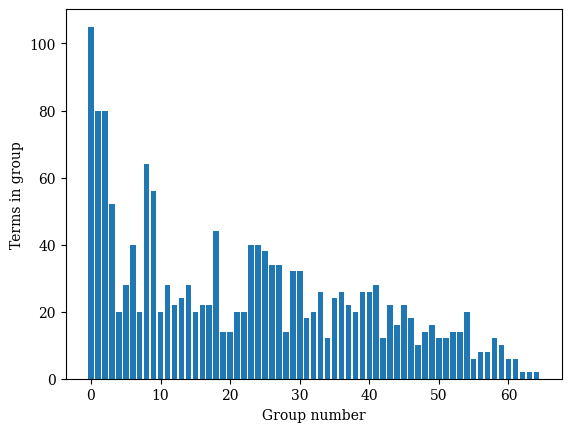

In [345]:
plt.bar(range(len(groups)), [len(group) for group in groups])
plt.xlabel("Group number")
plt.ylabel("Terms in group");

##### Ethan / Ben

In [348]:
from typing import List, Tuple
from itertools import product
from functools import reduce
import numpy as np
import cirq

from qiskit.synthesis import stabilizer


# Hacky substitute for `from mitiq import PauliString` -- only used for conversion to Cirq.
def PauliString(p):
    _string_to_gate_map = {"I": cirq.I, "X": cirq.X, "Y": cirq.Y, "Z": cirq.Z}
    
    return cirq.PauliString(
            coeff,
            (
                _string_to_gate_map[s].on(cirq.LineQubit(i))
                for (i, s) in enumerate(spec)
            ),
        )

def group_commutes(stabilizer_matrix: np.ndarray) -> bool:
    """Test if a group commutes."""

    nq = stabilizer_matrix.shape[0] // 2
    j = np.zeros((2 * nq, 2 * nq), dtype=bool)
    for i in range(nq):
        j[i, i+nq] = True
        j[i+nq, i] = True
    ip = np.mod(stabilizer_matrix.T @ j @ stabilizer_matrix, 2).astype(bool)
    return np.all(np.invert(ip))


def get_stabilizer_matrix_from_paulis(stabilizers, qubits):
    numq = len(qubits)
    nump = len(stabilizers)
    stabilizer_matrix = np.zeros((2*numq, nump))

    cirq.Z._name

    for i, paulistring in enumerate(stabilizers):
        for key, value in paulistring.items():
            if value._name == "X":
                stabilizer_matrix[int(key) + numq, i] = 1
            elif value._name == "Y":
                stabilizer_matrix[int(key), i] = 1
                stabilizer_matrix[int(key) + numq, i] = 1
            elif value._name == "Z":
                stabilizer_matrix[int(key), i] = 1

    return stabilizer_matrix


def get_stabilizer_matrix_signs(stabilizer_matrix):
    """If an input string contains Y, then we represent it by
    XZ = -Y. This function returns (-1)^k for each stabilizer,
    where k is the number of Y's in the original string.
    
    Arguments:
    stabilizer-matrix - a (2 numq) * nump matrix of the tableau.
    
    Returns:
    signs - List of booleans, where False means the sign is +1, and True
    means the sign is -1, i.e. we do (-1)^b = (-1)^(k mod 2)"""

    numq = len(stabilizer_matrix) // 2
    nump = len(stabilizer_matrix[0])
    
    signs: List[bool] = []
    for i in range(nump):
        p = stabilizer_matrix[:, i]
        zs = p[:numq]
        xs = p[numq:]
        k = 0 # Number of Y's in this string.
        for z, x in zip(zs, xs):
            if z == 1.0 and x == 1.0:
                k += 1
        signs.append(k % 2 != 0)
    return signs


def get_paulis_from_stabilizer_matrix(stabilizer_matrix):
    paulis = []
    nump = len(stabilizer_matrix[0])
    numq = len(stabilizer_matrix) // 2
    for j in range(nump):
        p = ""
        for i in range(numq):
            if stabilizer_matrix[i,j] == stabilizer_matrix[i + numq,j] == 1:
                p += "Y"
            elif stabilizer_matrix[i,j] == 1:
                p += "Z"
            elif stabilizer_matrix[i+numq,j] == 1:
                p += "X"
            else:
                p += "I"
        paulis.append(PauliString(p)._pauli)
    return paulis


def get_linearly_independent_set(stabilizer_matrix: np.ndarray) -> np.ndarray:
    """Use the Gaussian elimination to get the linearly-independent set of vectors.
    
    Returns
    independent_columns - Matrix with the linearly independent columns."""

    # Convert to bool for mod 2 arithmetic.
    bool_sm = stabilizer_matrix.astype(bool)
    reduced_matrix = binary_gaussian_elimination(bool_sm)
    # print("reduced stabilizer matrix=\n", reduced_matrix)
    # Find the pivot columns.
    next_pivot = 0 # Row of next pivot
    pivot_columns: List[int] = []
    for j in range(reduced_matrix.shape[1]):
        if next_pivot >= reduced_matrix.shape[0]:
            break
        if reduced_matrix[next_pivot, j]:
            pivot_columns.append(j)
            next_pivot += 1
    # print("pivot columns:\n", pivot_columns)
    independent_columns = stabilizer_matrix[:, pivot_columns]
    assert independent_columns.shape[0] == stabilizer_matrix.shape[0], \
        f"{independent_columns.shape[0]} != {stabilizer_matrix.shape[0]}"
    assert independent_columns.shape[1] <= stabilizer_matrix.shape[1], \
        f"{independent_columns.shape[1]} != {stabilizer_matrix.shape[1]}"
    return independent_columns


def binary_gaussian_elimination(matrix: np.ndarray) -> np.ndarray:
    """Do Gaussian elimination on the matrix to get it into RREF."""

    do_print = False

    next_row = 0 # Row that will contain the next pivot.
    mat = matrix.copy()
    if do_print:
        print("Starting:\n", mat)
    for j in range(mat.shape[1]):
        if do_print:
            print(f"On column {j}.")
        # If a row i >= next_row exists s.t. mat[i, j] == True,
        # Swap rows i and next_row.
        found = False
        for i in range(next_row, mat.shape[0]):
            if mat[i, j]:
                if do_print:
                    print(f"Found True value at row {i}.")
                found = True
                if i != next_row:
                    if do_print:
                        print(f"Swapping {i} <-> {next_row}.")
                    # Swap R_i <-> R_j
                    temp = mat[next_row, :].copy()
                    mat[next_row, :] = mat[i, :]
                    mat[i, :] = temp
                    if do_print:
                        print(mat)
                break
            
        if found:
            if do_print:
                print(f"True at element {next_row}, {j}")
            for i in range(next_row+1, mat.shape[0]):
                if mat[i, j]:
                    if do_print:
                        print(f"XORing row {i} with row{j}.")
                    mat[i, :] ^= mat[next_row, :]
                    if do_print:
                        print(mat)
            next_row += 1
    if do_print:
        print("Final reduced matrix\n", mat)
    return mat


def binary_matrix_rank(mat: np.ndarray) -> np.ndarray:
    """Get rank of binary matrix by doing Gaussian elmination, then count the
    number of pivot columns.
    Example:
    For [[True, False, True], [True, True, False], [False, True, True]], we should get rank 2,
    because [True True False] + [False True True] = [True False True]"""

    mat_reduced = binary_gaussian_elimination(mat)
    num_pivots = 0
    next_pivot = 0 # Location of next pivot row.
    for j in range(mat_reduced.shape[1]):
        # First check that all element below [next_pivot, j] are False:
        if next_pivot < mat_reduced.shape[0] - 1:
            all_zero_below = np.all(np.invert(mat_reduced[(next_pivot+1):, j]))
        else:
            all_zero_below = True
        if mat_reduced[next_pivot, j] and all_zero_below:
            num_pivots += 1
            next_pivot += 1
    return num_pivots


def assert_no_zero_column_in_matrix(matrix):
    """Assert that no column in the matrix is all zeros."""

    for j in range(matrix.shape[1]):
        assert not np.all(matrix[:, j] == 0.0), \
            f"Column {j} is all zeros."


def get_measurement_circuit(stabilizer_matrix):
    numq = len(stabilizer_matrix) // 2 # number of qubits
    nump = len(stabilizer_matrix[0]) # number of paulis
    z_matrix = stabilizer_matrix.copy()[:numq]
    x_matrix = stabilizer_matrix.copy()[numq:]

    assert_no_zero_column_in_matrix(stabilizer_matrix)

    # if nump > 2 * numq:
    #     raise ValueError(f"nump = {nump} > 2 * numq = 2 * {numq}. Set might be linearly-dependent.")

    # if nump > numq:
    #     raise ValueError(f"nump = {nump} > numq = {numq}. More columns than qubits.")
    
    # if nump < numq:
    #     raise ValueError("nump = {nump} < numq = {numq}.")

    measurement_circuit = cirq.Circuit()
    qreg = cirq.LineQubit.range(numq)

    # print("Strating elimination.")

    # Find a combination of rows to make X matrix have rank nump
    for row_combination in product(['X', 'Z'], repeat=numq):
        candidate_matrix = np.array([
            z_matrix[i] if c=="Z" else x_matrix[i] for i, c in enumerate(row_combination)
        ])

        # Apply Hadamards to swap X and Z rows to transform X matrix to have rank nump
        # rank = np.linalg.matrix_rank(candidate_matrix)
        rank = binary_matrix_rank(candidate_matrix.astype(bool))
        # print("rank =", rank)
        if rank == nump:
            for i, c in enumerate(row_combination):
                if c == "Z":
                    z_matrix[i] = x_matrix[i]
                    measurement_circuit.append(cirq.H.on(qreg[i]))
            x_matrix = candidate_matrix
            break
    
    for j in range(min(nump, numq)):
        if x_matrix[j,j] == 0:
            # Find i > j s.t. x_matrix[i, j] = 1.0.
            found = False
            for i in range(j + 1, numq):
                if x_matrix[i, j] != 0:
                    found = True
                    break
            #i = j + 1
            #while x_matrix[i,j] == 0:
            #    i += 1

            # If i was found, apply a SWAP i <-> j.
            if found:
                x_row = x_matrix[i].copy()
                x_matrix[i] = x_matrix[j]
                x_matrix[j] = x_row

                z_row = z_matrix[i].copy()
                z_matrix[i] = z_matrix[j]
                z_matrix[j] = z_row

                measurement_circuit.append(cirq.SWAP.on(qreg[j], qreg[i]))

        for i in range(j + 1, numq):
            if x_matrix[i,j] == 1:
                x_matrix[i] = (x_matrix[i] + x_matrix[j]) % 2
                z_matrix[j] = (z_matrix[j] + z_matrix[i]) % 2

                measurement_circuit.append(cirq.CNOT.on(qreg[j], qreg[i]))

    # print("Before CNOT gates:")
    # print("X=\n", x_matrix)
    # print("Z=\n", z_matrix)
    for j in range(nump-1, 0, -1):
        for i in range(j):
            if x_matrix[i, j] == 1:
                x_matrix[i] = (x_matrix[i] + x_matrix[j]) % 2
                z_matrix[j] = (z_matrix[j] + z_matrix[i]) % 2

                measurement_circuit.append(cirq.CNOT.on(qreg[j], qreg[i]))

    # print("Before S and CZ gates:")
    # print("X=\n", x_matrix)
    # print("Z=\n", z_matrix)
    for i in range(nump):
        if z_matrix[i,i] == 1:
            # z_matrix[i,i] = 0
            for p in range(nump):
                z_matrix[i, p] = (z_matrix[i, p] + x_matrix[i, p]) % 2
            measurement_circuit.append(cirq.S.on(qreg[i]))
        
        for j in range(i):
            if z_matrix[i,j] == 1:
                # z_matrix[i,j] = 0
                # z_matrix[j,i] = 0
                for p in range(nump):
                    z_matrix[i, p] = (z_matrix[i, p] + x_matrix[j, p]) % 2
                    z_matrix[j, p] = (z_matrix[j, p] + x_matrix[i, p]) % 2
                measurement_circuit.append(cirq.CZ.on(qreg[j], qreg[i]))

    # print("Before final Hadamards:")
    # print("X=\n", x_matrix)
    # print("Z=\n", z_matrix)
    for i in range(nump):
        row = x_matrix[i].copy()
        x_matrix[i] = z_matrix[i]
        z_matrix[i] = row

        measurement_circuit.append(cirq.H.on(qreg[i]))

    # print("After final Hadamards:")
    # print("X=\n", x_matrix)
    # print("Z=\n", z_matrix)

    # Check to see if any 1's are left over the in the X matrix.
    # If X_ij == 1 and Z_ij == 1, 
    for i in range(x_matrix.shape[0]):
        for j in range(x_matrix.shape[1]):
            if x_matrix[i, j] != 0.:
                print(f"Non-zero value in X at ({i}, {j}).")
                if z_matrix[i, j] != 0.:
                    print("Matching 1 in Z matrix.")
                else:
                    print("No matching 1 in Z.")

    return measurement_circuit, np.concatenate((z_matrix, x_matrix))


def get_measurement_circuit_tcc(stabilizer_matrix, distance):
    numq = len(stabilizer_matrix) // 2 # number of qubits
    nump = len(stabilizer_matrix[0]) # number of paulis
    z_matrix = stabilizer_matrix.copy()[:numq]
    x_matrix = stabilizer_matrix.copy()[numq:]

    measurement_circuit = cirq.Circuit()
    qreg = cirq.LineQubit.range(numq)

    # Compute a combination of rows to make X matrix have rank (mod 2) nump
    row_combination_pattern = ""
    pi = 0
    while len(row_combination_pattern) < numq:
        row_combination_pattern = row_combination_pattern + "XXXZXZ" + "XZXZXZ"*pi
        pi += 1
    row_combination = row_combination_pattern[:numq-distance+2] + "Z"*(distance-2)
    candidate_matrix = np.array([
        z_matrix[i] if c=="Z" else x_matrix[i] for i, c in enumerate(row_combination)
    ])

    # Apply Hadamards to swap X and Z rows to transform X matrix to have rank nump
    if binary_matrix_rank(candidate_matrix) == nump:
        for i, c in enumerate(row_combination):
            if c == "Z":
                z_matrix[i] = x_matrix[i]
                measurement_circuit.append(cirq.H.on(qreg[i]))
        x_matrix = candidate_matrix
    
    for j in range(nump):
        if x_matrix[j,j] == 0:
            i = j + 1
            while True:
                if np.isclose(x_matrix[i,j], 0.0):
                    i += 1
                else:
                    break

            x_row = x_matrix[i].copy()
            x_matrix[i] = x_matrix[j]
            x_matrix[j] = x_row

            z_row = z_matrix[i].copy()
            z_matrix[i] = z_matrix[j]
            z_matrix[j] = z_row

            measurement_circuit.append(cirq.SWAP.on(qreg[j], qreg[i]))

        for i in range(j + 1, numq):
            if x_matrix[i,j] == 1:
                x_matrix[i] = (x_matrix[i] + x_matrix[j]) % 2
                z_matrix[j] = (z_matrix[j] + z_matrix[i]) % 2

                measurement_circuit.append(cirq.CNOT.on(qreg[j], qreg[i]))

    for j in range(nump-1, 0, -1):
        for i in range(j):
            if x_matrix[i, j] == 1:
                x_matrix[i] = (x_matrix[i] + x_matrix[j]) % 2
                z_matrix[j] = (z_matrix[j] + z_matrix[i]) % 2

                measurement_circuit.append(cirq.CNOT.on(qreg[j], qreg[i]))

    for i in range(nump):
        if z_matrix[i,i] == 1:
            z_matrix[i,i] = 0
            measurement_circuit.append(cirq.S.on(qreg[i]))
        
        for j in range(i):
            if z_matrix[i,j] == 1:
                z_matrix[i,j] = 0
                z_matrix[j,i] = 0
                measurement_circuit.append(cirq.CZ.on(qreg[j], qreg[i]))

    for i in range(nump):
        row = x_matrix[i].copy()
        x_matrix[i] = z_matrix[i]
        z_matrix[i] = row

        measurement_circuit.append(cirq.H.on(qreg[i]))
    
    return measurement_circuit, np.concatenate((z_matrix, x_matrix))


def is_pauli_diagonal(pstring: cirq.PauliString) -> bool:
    """Tests if a given PauliString is diagonal."""

    for _, pauli in pstring.items():
        if not (pauli == cirq.I or pauli == cirq.Z):
            return False
    return True


def _check_x_bits_all_zero(stabilizer_matrix: np.ndarray):
    """Check that the lower half of the stabilizer matrix has all 0's."""

    numq = len(stabilizer_matrix) // 2
    s_x = stabilizer_matrix[numq:]
    if not np.all(np.invert(s_x.astype(bool))):
        print(f"WARNING S_x =\n{s_x}\nsize {s_x.shape} has ones in it.\nS=\n{stabilizer_matrix}")


def _assert_no_identity_column(stabilizer_matrix: np.ndarray):
    """Assert that there is no column that is all identity."""

    for j in range(stabilizer_matrix.shape[1]):
        assert not np.invert(stabilizer_matrix[:, j].astype(bool)).all(), f"{stabilizer_matrix[:, j]}"


def diagonalize_pauli_strings(
    paulis: List[cirq.PauliString], qs: List[cirq.Qid]
) -> Tuple[cirq.Circuit, List[cirq.PauliString]]:
    """Diagonalize a set of Pauli strings, returning the diagonalizing
    circuit and the list of diagonalized strings."""

    stabilizer_matrix = get_stabilizer_matrix_from_paulis(paulis, qs)
    # _assert_no_identity_column(stabilizer_matrix)
    for j in range(stabilizer_matrix.shape[1]):
        if np.all(np.invert(stabilizer_matrix[:, j].astype(bool))):
            stabilizer_matrix = np.delete(stabilizer_matrix, j, 1)
            break
    assert group_commutes(stabilizer_matrix)
    # if stabilizer_matrix.shape[1] > stabilizer_matrix.shape[0] // 2:
    #     print("Using Gram-Schmidt.")
    #     print(stabilizer_matrix)
    #     print(f"Matrix has {stabilizer_matrix.shape[1]} columns.")
    #     reduced_stabilizer_matrix = get_linearly_independent_set(stabilizer_matrix)
    #     print(f"After, matrix has {reduced_stabilizer_matrix.shape[1]} columns.")
    #     print(reduced_stabilizer_matrix)
    # else:
    #     reduced_stabilizer_matrix = stabilizer_matrix.copy()
    #     print("Not using Gram-Schmidt.")
    reduced_stabilizer_matrix = get_linearly_independent_set(stabilizer_matrix)
    measurement_circuit, diag_stabilizer_matrix = get_measurement_circuit(reduced_stabilizer_matrix)
    _check_x_bits_all_zero(diag_stabilizer_matrix)
    conjugated_strings: List[cirq.PauliString] = []
    for pstring in paulis:
        conjugated_string = pstring.after(measurement_circuit)
        assert is_pauli_diagonal(conjugated_string), \
            f"Pauli string {conjugated_string} is not diagonal. Originally was {pstring}"
        conjugated_strings.append(conjugated_string)
    return measurement_circuit, conjugated_strings

In [ ]:
measurement_circuits = []
conjugated_paulis = []
for i, group in enumerate(groups_cirq):
    print(f"On group {i + 1} / {len(groups)}.")
    meas_circuit, conjugated_strings = diagonalize_pauli_strings(group, cirq.LineQubit.range(nqubits))
    measurement_circuits.append(meas_circuit)
    conjugated_paulis.append(conjugated_strings)

On group 1 / 65.
On group 2 / 65.
On group 3 / 65.
On group 4 / 65.
On group 5 / 65.
On group 6 / 65.
On group 7 / 65.
On group 8 / 65.
On group 9 / 65.
On group 10 / 65.
On group 11 / 65.
On group 12 / 65.
On group 13 / 65.
On group 14 / 65.
On group 15 / 65.
On group 16 / 65.
On group 17 / 65.
On group 18 / 65.
On group 19 / 65.
On group 20 / 65.


##### Stim

In [223]:
from typing import Tuple, List
import stim
import stimcirq


def cirq_pstring_to_stim(pstring: cirq.PauliString, qs: List[cirq.Qid]) -> Tuple[float, stim.PauliString]:
    """Convert a (sparse) cirq PauliString to a stim PauliString. We ignore the sign of the cirq object,
    passing the coefficient back instead."""

    ps_dense = pstring.dense(qs)
    # Build the string specifying a stim.PauliString.
    stim_spec = "+"
    for p in ps_dense.pauli_mask:
        if p == 0:
            stim_spec += "_"
        elif p == 1:
            stim_spec += "X"
        elif p == 2:
            stim_spec += "Y"
        else:
            stim_spec += "Z"
    return (pstring.coefficient, stim.PauliString(stim_spec))


def force_abelian(coeffs: List[float], pstrings: List[stim.PauliString]) -> Tuple[List[float], List[stim.PauliString]]:
    """Flip signs on Pauli strings so that they commute. Pass coefficients so that we can compensate for flipping signs."""

    assert len(coeffs) == len(pstrings)

    flipped_coeffs: List[float] = []
    flipped_pstrings: List[stim.PauliString] = []
    for coeff, ps1 in zip(coeffs, pstrings):
        # print(f"ps1 = {ps1}")
        found = False
        for i in range(len(flipped_pstrings)):
            for j in range(i):
                ps2 = flipped_pstrings[i]
                ps3 = flipped_pstrings[j]
                prod = ps2 * ps3
                prod_without_sign = prod.sign * prod
                ps1_without_sign = ps1.sign * ps1
                # print(f"prod = {prod}")
                # print(f"prod_without_sign = {prod_without_sign}")
                if prod_without_sign == ps1_without_sign:
                    found = True
                    # print(f"Found pair {ps2} * {ps3} ~= {ps1}")
                    # print(prod.sign == ps1.sign)
                    flipped_coeffs.append(-1. * coeff)
                    flipped_pstrings.append(prod)
                    # print(f"Appending {prod}")
                    break
        if not found:
            flipped_coeffs.append(coeff)
            flipped_pstrings.append(ps1)
    return (flipped_coeffs, flipped_pstrings)


def stim_string_is_diagonal(pstring: stim.PauliString) -> bool:
    """Check that a stim PauliString is diagonal."""

    x_or_y_found = False
    for p in pstring:
        if p == 1 or p == 2:
            x_or_y_found = True
    return not x_or_y_found


def diagonalize_commuting_group(
    group: List[cirq.PauliString], qs: List[cirq.Qid]
) -> Tuple[List[float], List[stim.PauliString], stim.Circuit]:
    """Take a k-commuting group and diagonalize the strings with a Clifford circuit."""
    
    # Flip signs on the coefficients and the strings s.t. the set if from
    # an Abelian group.
    coeffs: List[float] = []
    stim_strings: List[stim.PauliString] = []
    for pstring in group:
        coeff, stim_string = cirq_pstring_to_stim(pstring, qs)
        coeffs.append(coeff)
        stim_strings.append(stim_string)
    new_coeffs, new_strings = force_abelian(coeffs, stim_strings)
    
    # Stim says the resulting circuit will diagonalize the given strings,
    # so long as they are all from an Abelian group.
    tab = stim.Tableau.from_stabilizers(new_strings, allow_redundant=True, allow_underconstrained=True)
    ckt = tab.to_circuit()

    # Get strings conjugated by the circuit, and check that they are diagonal.
    conjugated_strings: List[stim.PauliString] = []
    for pstring in new_strings:
        conj_string = pstring.before(ckt)
        if not stim_string_is_diagonal(conj_string):
            raise AssertionError(f"Mapping {pstring} -> {conj_string} does not diagonalize.")
        conjugated_strings.append(conj_string)
    return(new_coeffs, conjugated_strings, ckt)

In [224]:
stabilizers = [stim.PauliString("XX"), stim.PauliString("ZZ"), -stim.PauliString("YY")]
circuit = stimcirq.stim_circuit_to_cirq_circuit(
    stim.Tableau.from_stabilizers(stabilizers, allow_redundant=True).to_circuit()
)

In [225]:
qubits_cirq = cirq.LineQubit.range(nqubits)

In [228]:
all_results = []
for i, group in enumerate(groups_cirq[1:]):
    print(f"On group {i + 1} / {len(groups)}.", end="\r")
    new_coeffs, new_strings, ckt = diagonalize_commuting_group(group, qubits_cirq)
    all_results.append((group, new_coeffs, new_strings, ckt))

On group 442 / 443.

In [232]:
stimcirq.stim_circuit_to_cirq_circuit(all_results[1][3])

┌──┐       ┌──┐               ┌──┐               ┌──┐               ┌──┐                                                                           ┌──┐       ┌──┐           ┌──┐           ┌──┐
0: ────X───@────X─────X────X──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       │   │    │     │    │
1: ────┼───┼────┼H────@────┼H────────X────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       │   │    │          │         │
2: ────┼───┼────┼H─────────@─────H───@───H────X───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       │   │    │                             │
3: ────┼───┼────┼─────────────────────────────┼X────@───X───@────X────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       │   │    │                             ││    │   │   │    │
4: ────┼───┼────┼─────────────────────────────┼┼────┼───┼───┼────┼X────@───X───H────@─────X───X───X───X───X───X───X───X───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       │   │    │                             ││    │   │   │    ││    │   │        │     │   │   │   │   │   │   │   │
5: ────┼───┼────┼─────────────────────────────┼┼────┼───┼───┼────┼┼────┼───┼────────┼H────@───┼───┼───┼───┼───┼───┼───┼───X───@───X───H───@───@───@───@───@───@────@─────X────────────────────────────────────────────────────────────────────────────────────────
       │   │    │                             ││    │   │   │    ││    │   │        │         │   │   │   │   │   │   │   │   │   │       │   │   │   │   │   │    │     │
6: ────┼───┼────┼─────────────────────────────┼┼────┼───┼───┼────┼┼────┼───┼────────┼H────────@───┼───┼───┼───┼───┼───┼───┼───┼───┼───H───X───┼───┼───┼───┼───┼────┼─────┼────@───────────────────────────────────────────────────────────────────────────────────
       │   │    │                             ││    │   │   │    ││    │   │        │             │   │   │   │   │   │   │   │   │           │   │   │   │   │    │     │    │
7: ────┼───┼────┼─────────────────────────────┼@────X───@───┼────┼┼────┼───┼────────┼H────────────@───┼───┼───┼───┼───┼───┼───┼───┼───H───────X───┼───┼───┼───┼────┼─────┼────┼X────@───X────@────────────────────────────────────────────────────────────────────
       │   │    │                             │             │    ││    │   │        │                 │   │   │   │   │   │   │   │               │   │   │   │    │     │    ││    │   │    │
8: ────┼───┼────┼─────────────────────────────┼─────────────┼────┼┼────┼───┼────────┼H────────────────@───┼───┼───┼───┼───┼───┼───┼───H───────────X───┼───┼───┼────┼─────┼────┼┼────┼───┼────┼X────@───X────@─────────────────────────────────────────────────────
       │   │    │                             │             │    ││    │   │        │                     │   │   │   │   │   │   │                   │   │   │    │     │    ││    │   │    ││    │   │    │
9: ────┼───┼────┼─────────────────────────────┼─────────────┼────┼@────X───@────────┼H────────────────────@───┼───┼───┼───┼───┼───┼───H───────────────X───┼───┼────┼─────┼────┼┼────┼───┼────┼@────X───@────┼X────@───X───@───────────────────────────────────────
       │   │    │                             │             │    │                  │                         │   │   │   │   │   │                       │   │    │     │

## Connect to Qiskit runtime service

In [17]:
service = qiskit_ibm_runtime.QiskitRuntimeService() # This assumes a saved account.
computer = service.backend(ibm_computer)
sampler = Sampler(computer)

computer_fractional_gates = service.backend(ibm_computer, use_fractional_gates=True)
sampler_fractional_gates = Sampler(computer_fractional_gates)

qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-09-05 09:14:39,476: Default instance not set. Searching all available instances.


## Run experiment

In [18]:
base.measure_active()

In [19]:
compiled = qiskit.transpile(
    base,
    backend=computer,
    # initial_layout=qubits,
)
compiled.draw(fold=-1, idle_wires=False)

global phase: 3π/2
                 ┌───┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   ░    ┌─┐                                    
  q_28 -> 64 ────┤ X ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░────┤M├──────

In [20]:
compiled.count_ops()

OrderedDict([('sx', 285),
             ('rz', 156),
             ('cz', 140),
             ('measure', 14),
             ('x', 9),
             ('barrier', 1)])

In [21]:
to_run = compiled.copy()

## Noiseless result

In [24]:
job = AerSimulator().run(to_run, shots=nshots)

In [25]:
counts_all = {np.binary_repr(int(z, 16), len(qubits)): count for z, count in job.result().data().get("counts").items()}
counts_all

{'10011110110111': 1,
 '01101011110111': 2,
 '10011011110111': 28,
 '11100011110111': 4,
 '10101011101111': 111,
 '01011111010111': 52,
 '11010111010111': 102,
 '10101110101111': 56,
 '01101111001111': 15,
 '10011111001111': 270,
 '01101110110111': 57,
 '11100111001111': 22,
 '10101111010111': 49280}

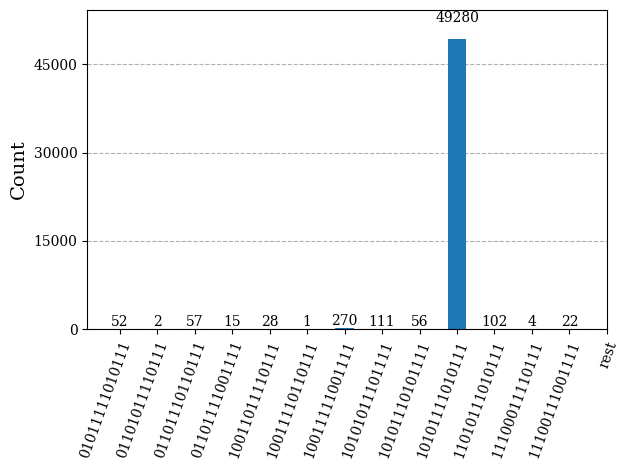

In [26]:
qiskit.visualization.plot_histogram(counts_all, number_to_keep=40)

In [28]:
from typing import Dict
import collections

import cirq

# def get_counts_for(qubit: int, counts: collections.Counter[str, int]) -> collections.Counter[int, int]:
#     qubit_counts = collections.Counter()
#     for key, value in counts.items():
#         k = list(key)[qubit]
#         qubit_counts[int(k)] += value
#     return qubit_counts


def _compute_expectation(
    pauli: cirq.PauliString,
    counts: Dict[str, int],
) -> float:
    if pauli is cirq.PauliString():
        return pauli.coefficient

    expectation = 0.0

    indices = [q.x for q in pauli.qubits]
    for key, value in counts.items():
        key = list(map(int, list(key[::-1])))
        expectation += (-1) ** sum([key[i] for i in indices]) * value

    return pauli.coefficient * expectation / sum(counts.values())


def compute_expectation(
    pauli_sum: cirq.PauliSum,
    counts: Dict[str, int],
) -> float:
    expval = 0.0
    for pauli in pauli_sum:
        expval += _compute_expectation(pauli, counts)
    return expval

In [36]:
compute_expectation(ham0, counts_all)

(-26.690655737059885+0j)

In [37]:
def get_counts_for(counts: dict[str, int], *qubits) -> Counter:
    new = Counter()
    for bitstring, number in counts.items():
        subselected = "".join(bitstring[q] for q in qubits)
        new[subselected] += number
    return new

## Noisy result

In [38]:
job = sampler.run([to_run], shots=nshots)
# job = service.job("d1vvr4gkchbs73ca903g")

In [39]:
all_counts = [result.data.meas.get_counts() for result in job.result()]

In [80]:
hamiltonian_cirq

cirq.PauliSum(cirq.LinearDict({frozenset(): (-46.85999302127529+0j), frozenset({(cirq.LineQubit(0), cirq.Z)}): (12.554433149358022+0j), frozenset({(cirq.LineQubit(0), cirq.Y), (cirq.LineQubit(1), cirq.Z), (cirq.LineQubit(2), cirq.Y)}): (0.12730881720827816+0j), frozenset({(cirq.LineQubit(2), cirq.X), (cirq.LineQubit(0), cirq.X), (cirq.LineQubit(1), cirq.Z)}): (0.12730881720827816+0j), frozenset({(cirq.LineQubit(0), cirq.Y), (cirq.LineQubit(2), cirq.Z), (cirq.LineQubit(3), cirq.Z), (cirq.LineQubit(1), cirq.Z), (cirq.LineQubit(4), cirq.Y)}): (2.2093389824883542e-07+0j), frozenset({(cirq.LineQubit(4), cirq.X), (cirq.LineQubit(0), cirq.X), (cirq.LineQubit(2), cirq.Z), (cirq.LineQubit(3), cirq.Z), (cirq.LineQubit(1), cirq.Z)}): (2.2093389824883542e-07+0j), frozenset({(cirq.LineQubit(0), cirq.Y), (cirq.LineQubit(4), cirq.Z), (cirq.LineQubit(2), cirq.Z), (cirq.LineQubit(6), cirq.Y), (cirq.LineQubit(3), cirq.Z), (cirq.LineQubit(5), cirq.Z), (cirq.LineQubit(1), cirq.Z)}): (-0.04373061707981958+

In [78]:
all_counts[0]

{'10111111010111': 2822,
 '10101111110111': 1390,
 '10100111010111': 622,
 '10101111010111': 16019,
 '10101110011111': 180,
 '10001111010111': 1452,
 '10101110010111': 655,
 '11101110110111': 117,
 '11011111000111': 35,
 '10101110100111': 169,
 '10000111010111': 124,
 '11011111001111': 22,
 '10101111000111': 1104,
 '10011111000111': 96,
 '10001110001111': 22,
 '01011111010111': 331,
 '11101111111101': 2,
 '00101101010111': 14,
 '01001011011111': 11,
 '11010111010111': 379,
 '01011111100111': 6,
 '11001111010111': 303,
 '00110110010111': 2,
 '00111111010111': 367,
 '10101111011111': 1133,
 '10101110001111': 100,
 '00101111010111': 1115,
 '10001110011111': 14,
 '01011110001111': 6,
 '01101110110111': 266,
 '10110111010111': 164,
 '10110011101111': 6,
 '10011111010111': 479,
 '10001110110111': 36,
 '01111111010111': 250,
 '01101010001111': 7,
 '10111110100111': 24,
 '10011110010111': 35,
 '10101110110111': 388,
 '11111111011111': 31,
 '01001011010111': 48,
 '00100110010111': 4,
 '11111011

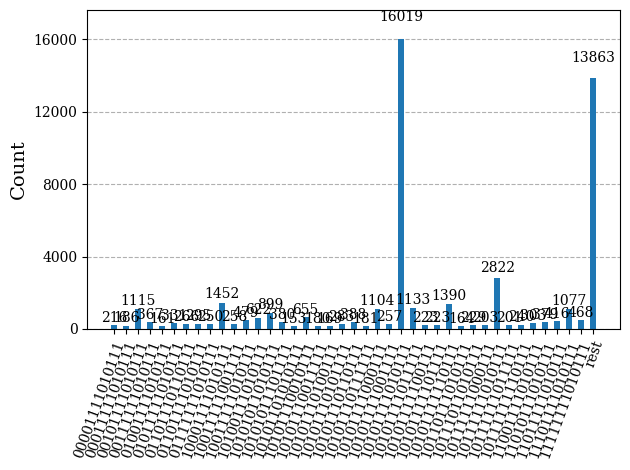

In [40]:
qiskit.visualization.plot_histogram(all_counts[0], number_to_keep=40)

In [41]:
compute_expectation(ham0, all_counts[0])

(-26.143443073312476+0j)

## Begin QEM

## With fractional gates

In [ ]:
job_fractional_gates = sampler_fractional_gates.run([to_run], shots=nshots)

In [ ]:
all_counts_frac = [result.data.measure.get_counts() for result in job_fractional_gates.result()]

In [ ]:
counts_frac = [get_counts_for(c, qubit1, qubit2) for c in all_counts_frac][0]
counts_frac

In [ ]:
exp_zz_frac = sum(
    count * (-1) ** sum(map(int, bitstring)) for bitstring, count in counts_frac.items()
) / nshots
exp_zz_frac

## With dynamical decoupling

In [ ]:
sampler_dd = Sampler(computer)
sampler_dd.options.dynamical_decoupling.enable = True
sampler_dd.options.dynamical_decoupling.sequence_type = "XpXm"

In [ ]:
job_dd = sampler_dd.run([to_run], shots=nshots)
# job_dd = service.job("d1vvt1okchbs73ca920g")

In [ ]:
all_counts_dd = [result.data.measure.get_counts() for result in job_dd.result()]

In [ ]:
counts_dd = [get_counts_for(c, qubit1, qubit2) for c in all_counts_dd][0]
counts_dd

In [ ]:
exp_zz_dd = sum(
    count * (-1) ** sum(map(int, bitstring)) for bitstring, count in counts_dd.items()
) / nshots
exp_zz_dd

## With readout error mitigation

In [ ]:
from qiskit_experiments.library import LocalReadoutError
from qiskit.result.distributions.quasi import QuasiDistribution 

from qiskit_experiments.library.characterization.analysis import LocalReadoutErrorAnalysis

In [ ]:
experiment = LocalReadoutError(qubits)
result = experiment.run(computer)

In [ ]:
mitigator = result.analysis_results("Local Readout Mitigator", dataframe=True).iloc[0].value

In [ ]:
correction_matrices = []
for i in range(len(qubits)):
    correction_matrices.append(mitigator.mitigation_matrix(qubits[i]))

counts_per_bit = []
for i in range(len(qubits)):
    counts_per_bit.append(get_counts_for(all_counts[0],i))

margdist_per_bit = []
for i in range(len(qubits)):
    margdist_per_bit.append(np.array([counts_per_bit[i].get("0"), counts_per_bit[i].get("1")]) / nshots)

corrected_margdist_per_bit = []
for i in range(len(qubits)):
    corrected_margdist_per_bit.append(mitigator.mitigation_matrix(qubits[i]) @ margdist_per_bit[i])

new_bits = []
for i in range(len(qubits)):
    new_bits.append(np.random.choice([0, 1], size=nshots, p=corrected_margdist_per_bit[i]))

corrected_bitstrings = ["".join(str(new_bits[i][j]) for i in range(len(qubits))) for j in range(nshots)]
corrected_counts = Counter(corrected_bitstrings)

In [ ]:
def apply_rem(
    counts: dict[str, int], 
    mitigator: "qiskit_experiments.LocalReadoutMitigator",
    *qubits) -> dict[str: int]:
    counts = get_counts_for(counts, *qubits)
    vec = np.zeros(2 ** len(qubits), dtype=float)
    for bitstring, count in counts.items():
        vec[int(bitstring, 2)] = count
    vec = vec / nshots
    assert np.allclose(vec.sum(), 1.0)

    mitigated_probs_quasi = mitigator.mitigation_matrix(qubits=qubits) @ vec
    mitigated_probs_quasi = QuasiDistribution({i: v for i, v in enumerate(mitigated_probs_quasi)})
    mitigated_counts = {
        bitstring: int(nshots * prob) for bitstring, prob in mitigated_probs_quasi.nearest_probability_distribution().binary_probabilities().items()
    }
    return mitigated_counts

In [ ]:
all_counts_rem = [apply_rem(counts, mitigator, qubit1, qubit2) for counts in all_counts]

In [ ]:
exp_zz_rem = sum(
    count * (-1) ** sum(map(int, bitstring)) for bitstring, count in all_counts_rem[0].items()
) / nshots
exp_zz_rem

In [ ]:
all_counts_dd_rem = [apply_rem(counts, mitigator, qubit1, qubit2) for counts in all_counts_dd]

In [ ]:
exp_zz_dd_rem = sum(
    count * (-1) ** sum(map(int, bitstring)) for bitstring, count in all_counts_dd_rem[0].items()
) / nshots
exp_zz_dd_rem

## With ZNE

In [ ]:
from mitiq import zne

In [ ]:
qasm2_circuit = qasm2.dumps(compiled)

compiled_cirq = circuit_from_qasm(qasm2_circuit.replace("qregless", "q"))

In [ ]:
scale_factors = [1, 3, 5]

In [ ]:
scaled_circuits_cirq = [zne.scaling.fold_global(compiled_cirq, scale_factor) for scale_factor in scale_factors]

In [ ]:
scaled_circuits = [to_qiskit(circuit) for circuit in scaled_circuits_cirq]
scaled_circuits = qiskit.transpile(
    scaled_circuits,
    backend=computer,
    initial_layout=qubits,
    optimization_level=0,
)

In [ ]:
to_run_scaled = [get_measured_circuit(scaled_circuit) for scaled_circuit in scaled_circuits]

In [ ]:
job_zne = sampler.run(to_run_scaled, shots=nshots)
# job_zne = service.job("d1vvtd1mr05s73a71lbg")

In [ ]:
all_counts_zne = [result.data.measure.get_counts() for result in job_zne.result()]

In [ ]:
counts_zne = [get_counts_for(c, qubit1, qubit2) for c in all_counts_zne]
counts_zne

In [ ]:
exp_zz_vals = [
    sum(
        count * (-1) ** sum(map(int, bitstring)) for bitstring, count in counts.items()
    ) / nshots
    for counts in counts_zne
]
exp_zz_vals

In [ ]:
plt.plot(scale_factors, exp_zz_vals, "--o", ms=10, mec="black", alpha=0.75)
plt.xlabel(r"Scale factor $\lambda$")
plt.ylabel(rf"$\langle ZZ \rangle (\lambda) $");

In [ ]:
exp_zz_zne = zne.inference.PolyFactory.extrapolate(
    scale_factors,
    exp_zz_vals,
    order=2,
)
exp_zz_zne

## ZNE + REM

In [ ]:
counts_zne_rem = [apply_rem(counts, mitigator, qubit1, qubit2) for counts in all_counts_zne]

In [ ]:
exp_zz_vals_zne_rem = [
    sum(
        count * (-1) ** sum(map(int, bitstring)) for bitstring, count in counts.items()
    ) / nshots
    for counts in counts_zne_rem
]
exp_zz_vals_zne_rem

In [ ]:
plt.plot(scale_factors, exp_zz_vals, "--o", ms=10, mec="black", alpha=0.75)
plt.xlabel(r"Scale factor $\lambda$")
plt.ylabel(rf"$\langle ZZ \rangle (\lambda) $");

In [ ]:
exp_zz_zne_rem = zne.inference.PolyFactory.extrapolate(
    scale_factors,
    exp_zz_vals_zne_rem,
    order=2,
)
exp_zz_zne_rem

## With decoherence renormalization

In [ ]:
from typing import List, Optional


def get_echo_circuit(
    computer: qiskit_ibm_runtime.IBMBackend,
    qubits: List[int],
    depth: int,
    seed: Optional[int] = None,
) -> qiskit.QuantumCircuit:
    """Return a (Loschmidt) echo circuit.

    The circuit is built by applying random single-qubit rotations (angles set by `seed`)
    and layers of two-qubit gates which can be implemented on the `computer` to create a 
    unitary U. Then, the inverse unitary U^dag is applied. 

    Args:
        computer: Determines the implementable gates (unitaries and couplings) for the echo circuit.
        qubits: A subset of qubits on the computer to implement the echo on.
        depth: The number of layers of single-qubit rotations/two-qubit gates in U.
        seed: Determines the angle of rotations for random single-qubit rotations in each layer.
    """
    # Get a random state (determines the angles in single-qubit rotations).
    rng = np.random.RandomState(seed)
    
    # Get the subgraph.
    subgraph_edges = []
    
    for edge in computer.coupling_map.get_edges():
        if edge[0] in qubits and edge[1] in qubits:
            subgraph_edges.append(edge)
    
    graph = nx.Graph()
    graph.add_edges_from(subgraph_edges)
    
    # Get the two-qubit gate from the device. TODO: Handle cases where the two-qubit gate is neither ECR nor CNOT.
    two_qubit_gate = qiskit.circuit.library.ECRGate() if "ecr" in computer.configuration().basis_gates else qiskit.circuit.library.CZGate()
    
    # Group edges into sets in which two-qubit gates can be performed in parallel.
    edge_sets = [set()]
    
    for edge_index, edge in enumerate(graph.edges):
        for i, edge_set in enumerate(edge_sets):
            edge_added_to_a_set = False
            node_list = [e[0] for e in edge_set] + [e[1] for e in edge_set]
            if edge[0] in node_list or edge[1] in node_list:
                continue
            else:
                edge_sets[i].add(edge)
                edge_added_to_a_set = True
                break
    
        if not edge_added_to_a_set:
            edge_sets.append(set())
            edge_sets[-1].add(edge)

    # print("Found edge sets:")
    # print(edge_sets)
    
    # Get a circuit with the qubits on the computer.
    circuit = qiskit.QuantumCircuit()
    circuit = qiskit.transpile(circuit, backend=computer)
    
    rng = np.random.RandomState(seed=seed)
    
    for _ in range(depth):
        for edge_set in edge_sets:
            # Do a layer of single-qubit rotations.
            for qubit in graph.nodes():
                circuit.append(qiskit.circuit.library.XGate(), qargs=[circuit.qubits[qubit]])
                circuit.append(qiskit.circuit.library.RZGate(2 * np.pi * rng.normal()), qargs=[circuit.qubits[qubit]])
                circuit.append(qiskit.circuit.library.XGate(), qargs=[circuit.qubits[qubit]])
    
            # Do a layer of two-qubit gates.
            for edge in edge_set:
                circuit.append(two_qubit_gate, qargs=[circuit.qubits[edge[0]], circuit.qubits[edge[1]]])
    
            # circuit.barrier()
    
    # Add the echo.
    circuit = circuit.compose(circuit.inverse())
    
    # Measure active qubits.
    if depth == 0:
        creg = qiskit.ClassicalRegister(len(graph.nodes()), name="meas")  # Note: This is hardcoded as `"meas"` to match the default name when `qiskit.QuantumCircuit.measure_active` is used.
        circuit.add_register(creg)
        for i, qubit in enumerate(sorted(graph.nodes())):
            circuit.measure(qubit, creg[i])
    else:
        circuit.measure_active()
    
    return circuit

In [ ]:
echo = get_echo_circuit(computer, qubits, depth=4, seed=1)

In [ ]:
echo.count_ops()

In [ ]:
job_echo = sampler.run([echo], shots=nshots)

In [ ]:
all_counts_echo = [result.data.measure.get_counts() for result in job_echo.result()]

In [ ]:
renormalization = 1.0 - all_counts_echo[0].get("0" * len(qubits), 0) / nshots
renormalization

In [ ]:
exp_zz_drn = exp_zz / renormalization
exp_zz_drn

## Plot results

In [ ]:
labels_vals = {
    "Ideal": exp_zz_ideal,
    "Hardware": exp_zz,
    "DD": exp_zz_dd,
    "REM": exp_zz_rem,
    "DD+REM": exp_zz_dd_rem,
    "ZNE": exp_zz_zne,
    "ZNE+REM": exp_zz_zne_rem,
}
colors = ["tab:green", "tab:red", "tab:grey", "tab:orange", "tab:pink", "tab:blue", "salmon"]
vals = list(labels_vals.values())
labels = list(labels_vals.keys())

plt.bar(range(len(vals)), vals, tick_label=labels, color=colors, edgecolor="black", alpha=0.75)
plt.ylabel(r"$\langle ZZ \rangle$");
plt.savefig("hchain_qem_v4.pdf")